<a href="https://colab.research.google.com/github/haticesezgin/bird_counter/blob/main/12RoBERTa%2C_adam%2C_2E_5%2C_bs_16%2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [4]:
!pip install transformers

import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import time

In [16]:
# Gerekli kütüphaneleri import et
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW  # AdamW doğru import edildi
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [6]:
seed = 12
torch.manual_seed(seed)

In [7]:
from google.colab import files
uploaded = files.upload()


Saving amazon_reviews_training.csv to amazon_reviews_training.csv


In [8]:
import pandas as pd
import io

# Yüklenen dosyayı pandas ile okuma
df = pd.read_csv(io.BytesIO(uploaded['amazon_reviews_training.csv']))


In [9]:
df.head()

,Unnamed: 0,RATING,VERIFIED_PURCHASE,REVIEW_TITLE,REVIEW_TEXT,NUM_NOUNS,NUM_VERBS,NUM_ADJECTIVES,NUM_ADVERBS,REVIEW_LENGTH,...,TITLE_LENGTH,AVERAGE_RATING,RATING_DEVIATION,NUM_REVIEWS,READABILITY_FRE,SENTIMENT_CATEGORY_ENCODED,RATING_CATEGORY_ENCODED,COHERENT_ENCODED,AVG_WORD_LENGTH,LABEL_ENCODED
0,0,4,0,useful,think so product save day case need someth,4,5,1,5,116,...,6,4.0,0.0,1,105.66,1,1,1,4.375000,0
1,1,4,1,New era for batteries,lithium batteri new introduc market averag dev...,15,15,12,5,404,...,21,4.0,0.0,2,33.92,1,1,1,5.378378,0
2,2,3,0,doesn't swing very well.,purchas swing babi 6 month pretti grow -pron- ...,7,13,4,10,248,...,24,3.0,0.0,1,80.96,1,1,1,4.291667,0
3,3,4,0,Great computing!,look inexpen desk calcolatur be work ne issu t...,8,10,4,5,212,...,16,4.5,-0.5,2,71.14,0,1,0,4.352941,0
4,4,4,0,Only use twice a week,use twice week result great tooth whiten solut...,14,12,7,4,331,...,21,4.5,-0.5,2,76.56,1,1,1,4.950000,0


In [10]:
# Bagi dataset menjadi data training dan data testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenisasi data menggunakan tokenizer dari Roberta
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_df['REVIEW_TEXT'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['REVIEW_TEXT'].tolist(), truncation=True, padding=True, max_length=512)

# Konversi data ke dalam format tensor
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_df['VERIFIED_PURCHASE'].tolist()))

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_df['VERIFIED_PURCHASE'].tolist()))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [11]:

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
dropout_rate = 0.5
model.config.hidden_dropout_prob = dropout_rate
model.config.attention_probs_dropout_prob = dropout_rate

In [ ]:
# Train the roBERTa model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

optimizer = Adam(model.parameters(), lr=2e-5, eps=1e-8)

total_steps = len(train_loader) * 2

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss()

#loss tiap epoch
loss_training = []
acurracy_training = []
f1_score_training = []

loss_testing = []
accuracy_testing = []
f1_score_testing = []

start_time = time.time()

for epoch in range(10):
    print('\nEpoch:', epoch+1)
    print('Training...')
    model.train()

    total_loss = 0

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 500 == 0 and step != 0:
            avg_train_loss = total_loss / step
            print('Batch', step, 'of', len(train_loader), '| Average Training Loss:', avg_train_loss)

    loss_training.append (total_loss)
    print('loss:', loss_training)

    print('Testing...')
    model.eval()

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

    predictions = []
    true_labels = []

    total_loss = 0

    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        predictions.extend(preds.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())

        total_loss += loss.item()

    loss_testing.append (total_loss)


    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('loss:', loss_testing)
    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

    accuracy_testing.append(accuracy)
    f1_score_testing.append(f1)

    end_time = time.time()
    runtime = end_time - start_time

    print(f"time runtime: {runtime} second")


Epoch: 1
Training...


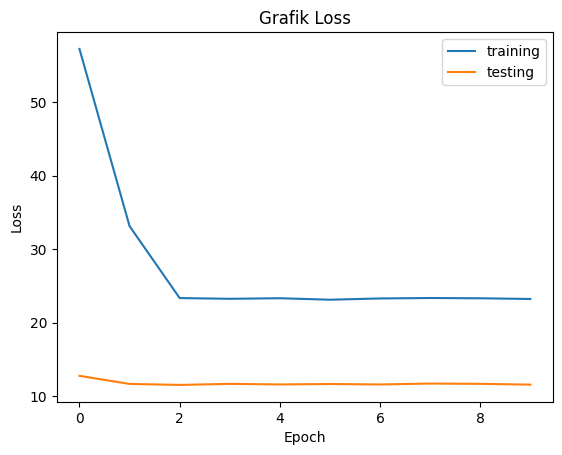

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_training, label="training")
plt.plot(loss_testing, label="testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Grafik Loss')
plt.legend()

Text(0.5, 1.0, 'Grafik Akurasi Testing')

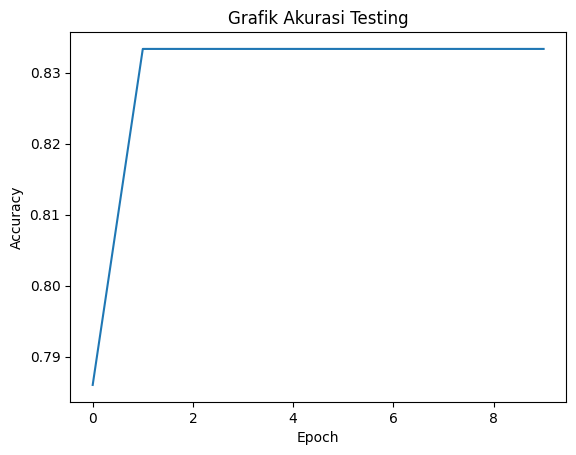

In [ ]:
plt.figure()
plt.plot(accuracy_testing)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Grafik Akurasi Testing')

Text(0.5, 1.0, 'Grafik F1 Score Testing')

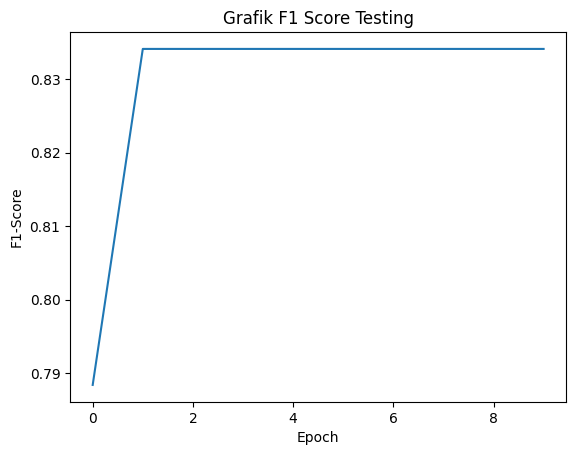

In [ ]:
plt.figure()
plt.plot(f1_score_testing)
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Grafik F1 Score Testing')

In [ ]:
tabel_hasil = pd.DataFrame(range(1, 11), columns=['ke-'])
tabel_hasil["loss_training"] = loss_training
tabel_hasil["loss_testing"] = loss_testing
tabel_hasil["accuracy"] = accuracy_testing
tabel_hasil["F1-Score"] = f1_score_testing

In [ ]:
tabel_hasil.head()

,ke-,loss_training,loss_testing,accuracy,F1-Score
0,1,57.224167,12.751031,0.786036,0.788419
1,2,33.119650,11.648383,0.833333,0.834081
2,3,23.329664,11.512965,0.833333,0.834081
3,4,23.228987,11.658142,0.833333,0.834081
4,5,23.307081,11.577494,0.833333,0.834081


In [ ]:
tabel_hasil.to_csv("123ROBERTA datasetjibran, adam, 2e-5, bs 16, 10 epoch.csv")